In [2]:
import pandas as pd
import numpy as np
from arcgis.features import GeoAccessor, GeoSeriesAccessor
df = pd.read_csv('https://raw.githubusercontent.com/nytimes/covid-19-data/master/us-counties.csv?raw=true')
df = df.fillna(value={'fips': -1})
df = df.astype({'fips': 'int64'})
sdf = pd.DataFrame.spatial.from_featureclass(r"G:\courses\qmsa\Chapter15\Chapter15.gdb\USA_Counties_COVID")
df

,date,county,state,fips,cases,deaths
0,2020-01-21,Snohomish,Washington,53061,1,0
1,2020-01-22,Snohomish,Washington,53061,1,0
2,2020-01-23,Snohomish,Washington,53061,1,0
3,2020-01-24,Cook,Illinois,17031,1,0
4,2020-01-24,Snohomish,Washington,53061,1,0
...,...,...,...,...,...,...
98257,2020-04-28,Sublette,Wyoming,56035,1,0
98258,2020-04-28,Sweetwater,Wyoming,56037,10,0
98259,2020-04-28,Teton,Wyoming,56039,65,1
98260,2020-04-28,Uinta,Wyoming,56041,6,0


In [3]:
df = df.loc[df.state=='Louisiana']
sdf = sdf.loc[sdf.State=='Louisiana']

In [5]:
#df['fips'] = np.where((df.county == 'Unknown'),-1,df.fips)

datelist=df['date'].unique().tolist()
datelist = datelist[5:]
datelist

['2020-03-14',
 '2020-03-15',
 '2020-03-16',
 '2020-03-17',
 '2020-03-18',
 '2020-03-19',
 '2020-03-20',
 '2020-03-21',
 '2020-03-22',
 '2020-03-23',
 '2020-03-24',
 '2020-03-25',
 '2020-03-26',
 '2020-03-27',
 '2020-03-28',
 '2020-03-29',
 '2020-03-30',
 '2020-03-31',
 '2020-04-01',
 '2020-04-02',
 '2020-04-03',
 '2020-04-04',
 '2020-04-05',
 '2020-04-06',
 '2020-04-07',
 '2020-04-08',
 '2020-04-09',
 '2020-04-10',
 '2020-04-11',
 '2020-04-12',
 '2020-04-13',
 '2020-04-14',
 '2020-04-15',
 '2020-04-16',
 '2020-04-17',
 '2020-04-18',
 '2020-04-19',
 '2020-04-20',
 '2020-04-21',
 '2020-04-22',
 '2020-04-23',
 '2020-04-24',
 '2020-04-25',
 '2020-04-26',
 '2020-04-27',
 '2020-04-28']

In [6]:
import arcpy
moransIList = []
biglist = []
for idate in datelist:
    dateDF = df.loc[df.date==idate]
    print(idate)

    joinedDate = sdf.set_index('FIPSm').join(dateDF.set_index('fips')).fillna(value={'cases': 0, 'deaths': 0})
    outputLOC = r"G:\courses\qmsa\Chapter15\Chapter15.gdb\USA_Counties_COVID_" + str(idate).replace("-","_")
    #print(outputLOC)
    joinedDate["casesPerThousand"] = joinedDate["cases"] /  (joinedDate["Population"] / 1000)
    joinedDate["deathsPer100k"] = joinedDate["deaths"] /  (joinedDate["Population"] / 100000)
    joinedDate["date"] = idate
    joinedDate = joinedDate.fillna(value={'county': "", "state": ""})
    joinedDate.spatial.to_featureclass(location=outputLOC)
    moransI = arcpy.SpatialAutocorrelation_stats(outputLOC, "deathsPer100k","NO_REPORT","INVERSE_DISTANCE_SQUARED","EUCLIDEAN DISTANCE", "ROW")
    moransIList.append(moransI)
    print(moransI, joinedDate["deaths"].sum(), joinedDate["cases"].sum())
    biglist.append((moransI, joinedDate["deaths"].sum(), joinedDate["cases"].sum()))

2020-03-14
-0.023256 1.0 77.0
2020-03-15
-0.023256 2.0 103.0
2020-03-16
-0.023256 3.0 137.0
2020-03-17
-0.023256 5.0 196.0
2020-03-18
0.04312 7.0 278.0
2020-03-19
-0.028547 10.0 389.0
2020-03-20
-0.028547 10.0 532.0
2020-03-21
-0.020923 16.0 754.0
2020-03-22
-0.051706 20.0 826.0
2020-03-23
-0.088013 34.0 1160.0
2020-03-24
-0.042301 45.0 1378.0
2020-03-25
0.074585 64.0 1786.0
2020-03-26
0.118923 82.0 2293.0
2020-03-27
0.15349 118.0 2730.0
2020-03-28
0.218531 136.0 3306.0
2020-03-29
0.24944 152.0 3532.0
2020-03-30
0.341845 186.0 4011.0
2020-03-31
0.434367 236.0 5215.0
2020-04-01
0.46659 275.0 6396.0
2020-04-02
0.504082 309.0 9110.0
2020-04-03
0.557736 366.0 10255.0
2020-04-04
0.525665 412.0 12461.0
2020-04-05
0.493368 473.0 12975.0
2020-04-06
0.525241 509.0 14819.0
2020-04-07
0.53538 580.0 16235.0
2020-04-08
0.506154 650.0 16981.0
2020-04-09
0.529515 700.0 18232.0
2020-04-10
0.540747 753.0 19199.0
2020-04-11
0.512274 803 19960
2020-04-12
0.527367 837 20541
2020-04-13
0.493482 884 20960
2

In [7]:
c = 0
newlist = []
for item in biglist:
    newlist.append((datelist[c], float(item[0][0]), int(item[1]), int(item[2])))
    #float(item[0][1]), float(item[0][2])
    c=c+1


df = pd.DataFrame(newlist, columns =['date', 'I', 'deaths', 'cases']) 
#df['rolling'] = df['I'].rolling(window=3)
df = df.set_index('date')
df['deaths_n'] = df['deaths'] / df['deaths'].max()
df['cases_n'] = df['cases'] / df['cases'].max()

a=df[['I', 'deaths_n', 'cases_n']].rolling(5,center=True, min_periods=1).mean()
b=df[['I', 'deaths', 'cases']].rolling(5,center=True, min_periods=1).mean()

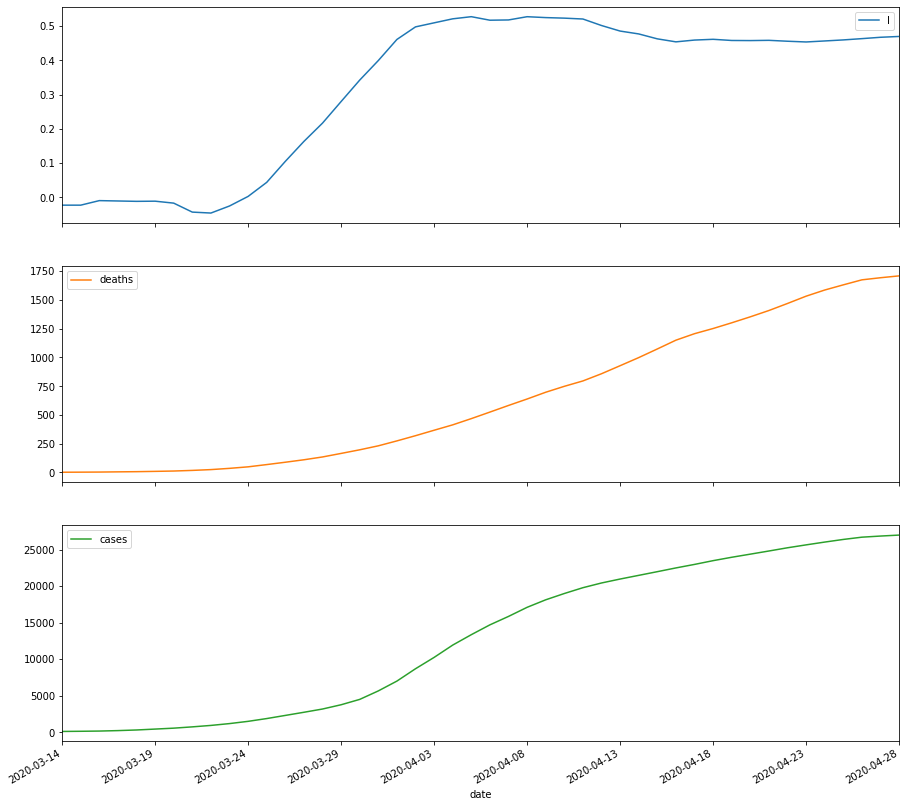

In [9]:
import matplotlib.pyplot as plt
axes = b.plot.line(subplots=True, figsize=(15,15))

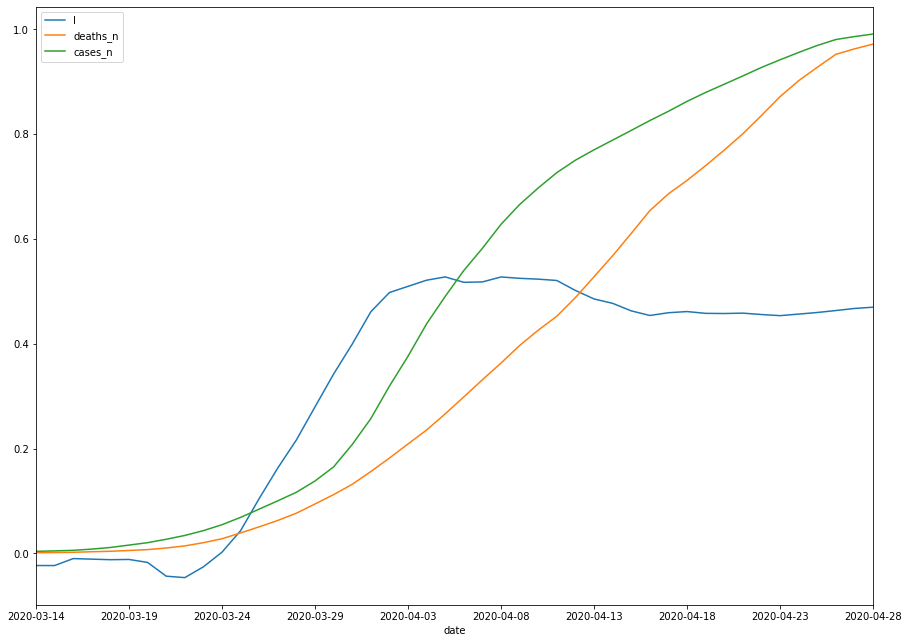

In [10]:
axes = a.plot.line(subplots=False, figsize=(15,11))